# Credit Card Kaggle- Fixing Imbalanced Dataset

## Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Inspiration

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
data = pd.read_csv('creditcard.csv', sep = ',')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
#Create independent and Dependent Features
columns = data.columns.tolist()
columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [6]:
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [7]:
# Store the variable we are predicting 
target = "Class"

# Define a random state 
state = np.random.RandomState(42)

X = data[columns]
Y = data[target]

# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


## Exploratory Data Analysis

In [8]:
data.isnull().values.any()

False

In [9]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes

0    284315
1       492
Name: Class, dtype: int64

Text(0, 0.5, 'Frequency')

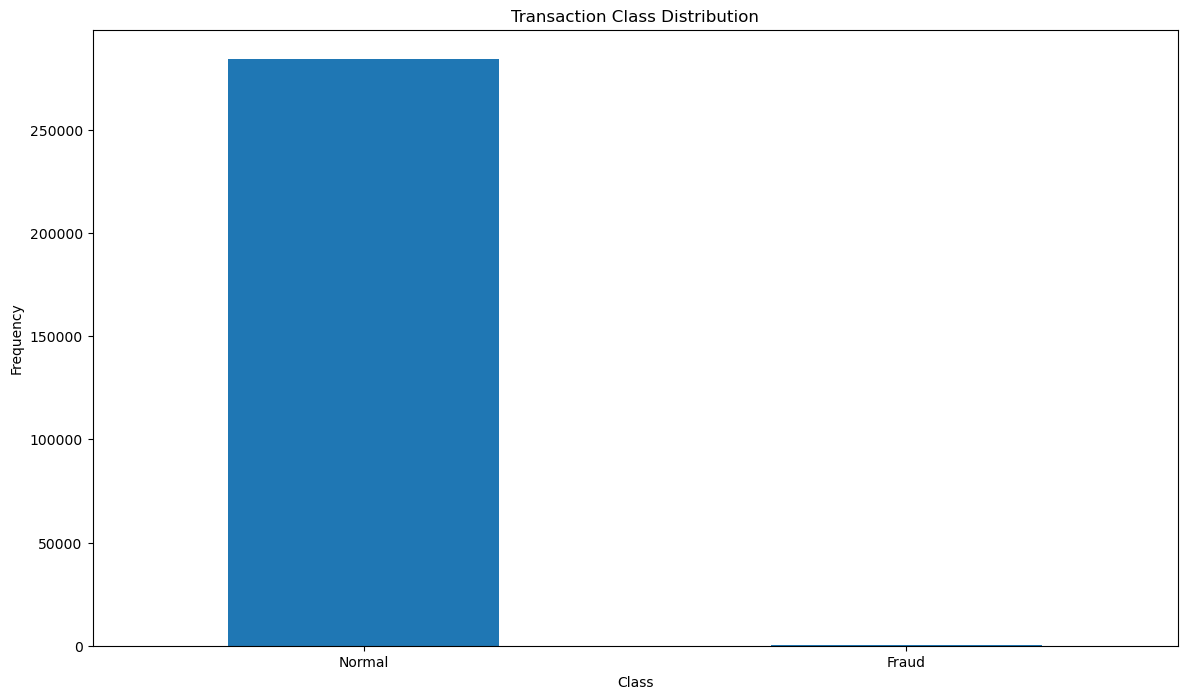

In [10]:
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [11]:
# Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]
normal = data[data['Class']==0]

In [12]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


## Handling the Imbalancy in the dataset using OverSampling method

In [13]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [14]:
# Implementing Oversampling for Handling Imbalanced 

smk = SMOTETomek(random_state=42)
X_res,Y_res=smk.fit_resample(X,Y)

In [15]:
X_res.shape, Y_res.shape

((567562, 30), (567562,))

In [16]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(Y_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 283781, 1: 283781})


## RandomOverSampler to handle imbalanced data

In [17]:
from imblearn.over_sampling import RandomOverSampler

In [19]:
os =  RandomOverSampler(sampling_strategy=0.5)

In [21]:
X_train_res, Y_train_res = os.fit_resample(X, Y)

In [22]:
X_train_res.shape,Y_train_res.shape

((426472, 30), (426472,))

In [23]:
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(Y_train_res)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 284315, 1: 142157})


In this example we use SMOTETomek which is a method of imblearn. SMOTETomek is a hybrid method which uses an under sampling method (Tomek) in with an over sampling method (SMOTE).

In [24]:
os_us = SMOTETomek(sampling_strategy=0.5)

In [25]:
X_train_res1, Y_train_res1 = os_us.fit_resample(X, Y)

In [26]:
X_train_res1.shape,Y_train_res1.shape

((424706, 30), (424706,))

In [27]:
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(Y_train_res1)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 283432, 1: 141274})
